Declaração de bibliotecas e funções de apoio

In [164]:
import seaborn
import itertools
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from abc import ABC, abstractmethod
from IPython.display import display
from sklearn.metrics import confusion_matrix


Calcular métricas de classificação (adaptado para multi-classe)

In [165]:
def evaluate_metrics(y_test: NDArray, y_predict: NDArray):
    y_test = y_test.flatten()
    y_predict = y_predict.flatten()
    n = y_test.shape[0]

    accuracy = np.sum(y_predict == y_test) / n

    unique_classes = np.unique(np.concatenate((y_test, y_predict)))

    precisions = []
    recalls = []
    f1_scores = []

    for cls in unique_classes:
        tp = np.sum((y_predict == cls) & (y_test == cls))
        fp = np.sum((y_predict == cls) & (y_test != cls))
        fn = np.sum((y_predict != cls) & (y_test == cls))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    metrics = {
        'accuracy': accuracy,
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1_scores),
    }
    return metrics

Declaração dos escaladores MinMax e ZScore

In [166]:
class Scaler(ABC):
    @abstractmethod
    def normalize(self, X: NDArray, update_params: bool = False) -> NDArray:
        pass

    @abstractmethod
    def denormalize(self, X: NDArray) -> NDArray:
        pass

class ZScore(Scaler):
    def __init__(self):
        self.mean: NDArray = None
        self.std: NDArray = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        mean = np.mean(X, axis=0) if self.mean is None or update_params else self.mean
        std = np.std(X, axis=0) if self.std is None or update_params else self.std

        self.mean = mean
        self.std = std

        return (X - mean) / (std + 1e-8)

    def denormalize(self, X: NDArray):
        return X * self.std + self.mean

class MinMax(Scaler):
    def __init__(self):
        self.min = None
        self.max = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        min_val = np.min(X, axis=0) if self.min is None or update_params else self.min
        max_val = np.max(X, axis=0) if self.max is None or update_params else self.max

        self.min = min_val
        self.max = max_val

        return (X - min_val) / (max_val - min_val + 1e-8)

    def denormalize(self, X: NDArray):
        return X * (self.max - self.min) + self.min


Implementação do MLP com a mesma interface do modelo do scikit learn para usar na validação cruzada

In [167]:
class Model(ABC):
    has_training_costs = False

    @abstractmethod
    def fit(self, X: NDArray, y: NDArray):
        pass

    @abstractmethod
    def predict(self, X: NDArray) -> NDArray:
        pass

class MLP(Model):
    has_training_costs = True

    def __init__(self, n_classes: int, hidden_layer_sizes: tuple[int, ...], learning_rate: float, epochs: int, momentum: float, batch_size: int = 32):
        self.n_classes = n_classes
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.momentum = momentum
        self.in_scaler = ZScore()
        self.weights, self.biases = [], []
        self.velocities_w, self.velocities_b = [], []
        self.costs, self.test_costs = [], []

    def _relu(self, Z):
        return np.maximum(0, Z)

    def _relu_derivative(self, Z):
        return Z > 0

    def _softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def _one_hot(self, y):
        y_onehot = np.zeros((y.shape[0], self.n_classes))
        y_onehot[np.arange(y.shape[0]), y.flatten().astype(int)] = 1
        return y_onehot

    def _forward(self, X: NDArray):
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            Z = X @ W + b
            X = self._relu(Z) if i < len(self.weights) - 1 else self._softmax(Z)

        return X

    def fit(self, X: NDArray, y: NDArray, X_test: NDArray, y_test: NDArray):
        X = self._preprocess_input(X, update_params=True)
        X_test = self._preprocess_input(X_test)
        y_onehot = self._one_hot(y)
        n, m = X.shape

        layer_sizes = [m, *self.hidden_layer_sizes, self.n_classes]
        self.weights = [np.random.randn(in_size, out_size) * np.sqrt(2. / in_size) for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]
        self.velocities_w = [np.zeros_like(w) for w in self.weights]
        self.velocities_b = [np.zeros_like(b) for b in self.biases]
        self.costs, self.test_costs = [], []

        for epoch in range(self.epochs):
            shuffled_indices = np.random.permutation(n)
            X_shuffled = X[shuffled_indices]
            y_onehot_shuffled = y_onehot[shuffled_indices]
            epoch_costs = []

            for i in range(0, n, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_onehot_shuffled[i:i+self.batch_size]
                batch_n = len(X_batch)

                activations = [X_batch]
                Zs = []
                A = X_batch
                for j, (W, b) in enumerate(zip(self.weights, self.biases)):
                    Z = A @ W + b
                    Zs.append(Z)
                    A = self._relu(Z) if j < len(self.weights) - 1 else self._softmax(Z)
                    activations.append(A)

                cost = -np.mean(np.sum(y_batch * np.log(A + 1e-8), axis=1))
                epoch_costs.append(cost)

                dZ = A - y_batch
                for j in range(len(self.weights) - 1, -1, -1):
                    dW = (activations[j].T @ dZ) / batch_n
                    db = np.sum(dZ, axis=0, keepdims=True) / batch_n

                    if j > 0:
                        dZ = (dZ @ self.weights[j].T) * self._relu_derivative(Zs[j-1])

                    self.velocities_w[j] = self.momentum * self.velocities_w[j] - self.learning_rate * dW
                    self.velocities_b[j] = self.momentum * self.velocities_b[j] - self.learning_rate * db
                    self.weights[j] += self.velocities_w[j]
                    self.biases[j] += self.velocities_b[j]

            self.costs.append(np.mean(epoch_costs))
            A_test = self._forward(X_test)
            y_test_onehot = self._one_hot(y_test)
            test_cost = -np.mean(np.sum(y_test_onehot * np.log(A_test + 1e-8), axis=1))
            self.test_costs.append(test_cost)

    def predict(self, X: NDArray):
        X = self._preprocess_input(X)
        probabilities = self._forward(X)
        return np.argmax(probabilities, axis=1)

    def _preprocess_input(self, X: NDArray, update_params=False):
        return self.in_scaler.normalize(X, update_params)


Classes para treinar vários modelos usando validação cruzada (K-Folds) e Grid Search

In [168]:
class KFoldTrainer:
    '''
    Treina um modelo (instanciado com hyper parâmetros), separando k partições de treino/validação
    Salva a média das métricas de cada validação feita
    '''
    def __init__(self, k: int, n_classes: int, dataset: NDArray, model: Model):
        self.k = k
        self.n_classes = n_classes
        self.dataset = dataset
        self.model = model
        self.metrics = None

    def fit(self):
        metrics = {
            'accuracy': np.zeros(self.k),
            'precision': np.zeros(self.k),
            'recall': np.zeros(self.k),
            'f1_score': np.zeros(self.k),
        }
        for i, dataset in enumerate(self._genereate_dataset_k_folds()):
            X_train, y_train, X_validation, y_validation = dataset
            train_params = [X_train, y_train]
            if self.model.has_training_costs:
                train_params.extend([X_validation, y_validation])

            self.model.fit(*train_params)

            y_predict = self.model.predict(X_validation)
            metrics_i = evaluate_metrics(y_validation, y_predict)
            for key, value in metrics_i.items():
                metrics[key][i] = value

        self.metrics = {
            key: np.mean(value)
            for key, value in metrics.items()
        }

    def _genereate_dataset_k_folds(self):
        np.random.shuffle(self.dataset)
        X, y = self.dataset[:, :-1], self.dataset[:, -1].astype(int).reshape((-1, 1))
        validation_size_percent = 1 / self.k

        n, _ = X.shape
        validation_size = ceil(n * validation_size_percent)
        for i in range(self.k):
            validation_index_start = i * validation_size
            validation_index_final = (i + 1) * validation_size if i < self.k - 1 else n

            X_validation = X[validation_index_start:validation_index_final]
            y_validation = y[validation_index_start:validation_index_final]
            X_train = np.concatenate([X[:validation_index_start], X[validation_index_final:]])
            y_train = np.concatenate([y[:validation_index_start], y[validation_index_final:]])

            yield X_train, y_train, X_validation, y_validation

class GridSearchTrainer:
    '''
    Instancia um modelo a partir de sua classe com cada combinação possível dos hyper parâmetros recebidos
    Chama o KFoldTrainer para fazer a validação cruzada para cada combinação de hyper parâmetros
    Salva as métricas, modelo (treinado), e hyper parâmetros escolhidos da melhor combinação encontrada (avaliado pela acurácia)
    '''
    def __init__(self, k: int, n_classes: int, dataset: NDArray, model_class: type[Model], hyper_params: dict[str, list]):
        self.k = k
        self.n_classes = n_classes
        self.dataset = dataset
        self.model_class = model_class
        self.hyper_params = hyper_params
        self.best_model = None
        self.best_hyper_params = None
        self.best_metrics = None

    def fit(self):
        params_names = list(self.hyper_params.keys())
        grid = list(itertools.product(*self.hyper_params.values()))

        best_metrics = None
        best_model = None
        best_hyper_params = None
        for params_values in grid:
            params = dict(zip(params_names, params_values))
            model = self.model_class(**params)

            k_fold_trainer = KFoldTrainer(self.k, self.n_classes, self.dataset, model)
            k_fold_trainer.fit()
            accuracy = k_fold_trainer.metrics['accuracy']

            if best_model is None or accuracy > best_metrics['accuracy']:
                best_metrics = k_fold_trainer.metrics
                best_model = model
                best_hyper_params = dict(zip(params_names, params_values))

        self.best_model = best_model
        self.best_hyper_params = best_hyper_params
        self.best_metrics = best_metrics


class KFoldMultiModelsTrainer(KFoldTrainer):
    '''
    Treina vários modelos separando o dataset em k partições de treinamento/teste para fazer validações cruzadas
    Chama o GridSearchTrainer para encontrar a melhor combinação de hyper parâmetros de um modelo, para cada conjunto de treinamento
    Para cada modelo, salva a média e o desvio padrão das métricas com a melhor combinação de hyper parâmetros para cada conjunto de treinamento
    '''
    def __init__(self, k: int, n_classes: int, dataset: NDArray, models: dict[str, tuple[type[Model], dict[str, list]]]):
        self.k = k
        self.n_classes = n_classes
        self.dataset = dataset
        self.models = models

    def fit(self):
        trained_models = dict()
        for model_name, value in self.models.items():
            model_class, hyper_params = value
            model_attributes = {
                'metrics_train': {
                    metric: np.zeros(self.k)
                    for metric in ['accuracy', 'precision', 'recall', 'f1_score']
                },
                'metrics_test': {
                    metric: np.zeros(self.k)
                    for metric in ['accuracy', 'precision', 'recall', 'f1_score']
                },
                'hyper_params': {
                    param: np.zeros(self.k, dtype=np.object_)
                    for param in hyper_params.keys()
                },
                'model': np.zeros(self.k, dtype=np.object_)
            }
            for i, dataset in enumerate(self._genereate_dataset_k_folds()):
                print(f"Treinando {model_name} no Fold {i+1}/{self.k}...")
                X_train, y_train, X_test, y_test = dataset
                dataset_train = np.c_[X_train, y_train]
                trainer = GridSearchTrainer(self.k, self.n_classes, dataset_train, model_class, hyper_params)
                trainer.fit()
                y_predict = trainer.best_model.predict(X_test)
                test_metrics = evaluate_metrics(y_test, y_predict)

                for metric in model_attributes['metrics_train'].keys():
                    model_attributes['metrics_train'][metric][i] = trainer.best_metrics[metric]
                    model_attributes['metrics_test'][metric][i] = test_metrics[metric]

                for param in model_attributes['hyper_params'].keys():
                    model_attributes['hyper_params'][param][i] = trainer.best_hyper_params[param]

                model_attributes['model'][i] = trainer.best_model

            trained_models[model_name] = model_attributes
        print("\nTreinamento concluído!")
        return trained_models

Funções auxiliares para plotagem

In [169]:
def plot_costs(costs: NDArray, test_costs: NDArray, title: str):
    plt.plot(costs)
    plt.plot(test_costs)
    plt.xlabel('Épocas')
    plt.ylabel('Entropia Cruzada')
    plt.title(f'Função Custo {title}')
    plt.legend(['Treinamento', 'Teste'])
    plt.show()

def extract_from_text(text: str):
        return float(text.split('%')[0])

def plot_models_metrics(trained_models: dict[str, dict[str, dict[str, float]]]):
    test_metrics = {name: results['metrics_test'] for name, results in trained_models.items()}

    table = pd.DataFrame(test_metrics).T.map(lambda x: f"{np.mean(x):.2%} ± {1.96 * np.std(x) / np.sqrt(len(x)):.2%}")
    table.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    table.index = test_metrics.keys()

    styled_table = table.style.apply(lambda col: ['font-weight:bold; color:red' if extract_from_text(x) == col.apply(extract_from_text).max() else '' for x in col])
    display(styled_table)

def plot_confusion_matrix(y_pred: NDArray, y_test: NDArray, title: str, class_names: list = None):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(title, fontsize=16)
    plt.ylabel('Classe Verdadeiro', fontsize=12)
    plt.xlabel('Classe Predita', fontsize=12)
    plt.show()


# Questão 02 -> items a,b

1. Lendo o dataset 'vowel.csv'
2. Escolhendo o MLP para fazer os treinamentos e validações.
3. Definindo os possíveis valores dos hiperparâmetros para o grid search.
4. Treinando os modelos usando 5 partições para testes cruzados e 5 partições internas para validação cruzada (no GridSearch).
5. Plotando a tabela com a média e o intervalo de confiança das métricas para cada modelo, e o gráfico dos custos do MLP + matriz de confusão.

Treinando MLP no Fold 1/5...
Treinando MLP no Fold 2/5...
Treinando MLP no Fold 3/5...
Treinando MLP no Fold 4/5...
Treinando MLP no Fold 5/5...

Treinamento concluído!


,Accuracy,Precision,Recall,F1 Score
MLP,96.06% ± 1.02%,96.14% ± 0.93%,95.89% ± 1.13%,95.89% ± 1.03%


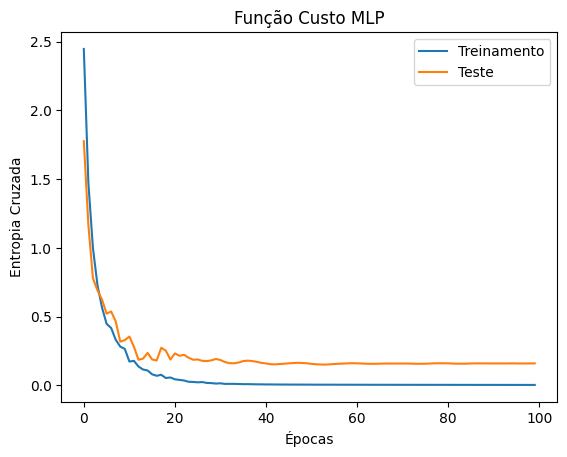

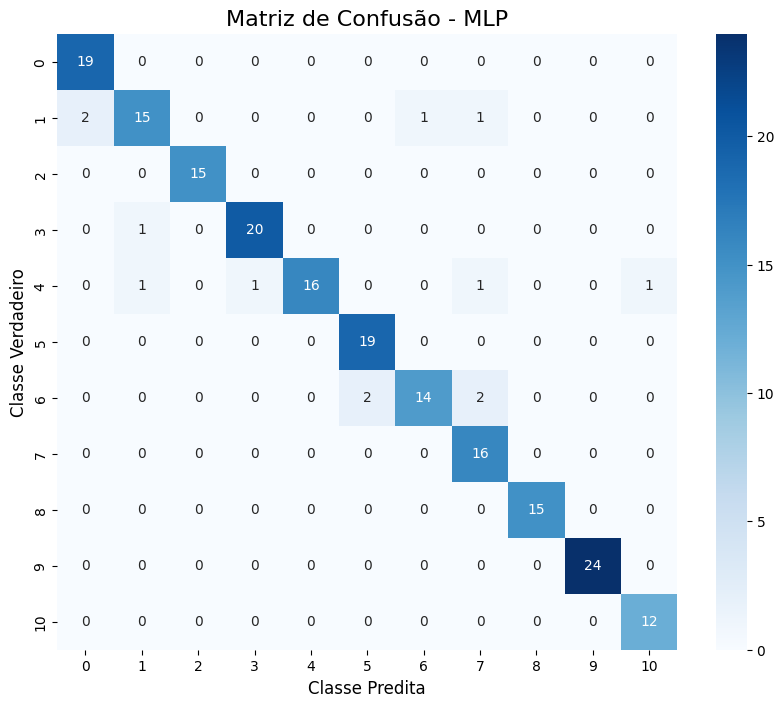

In [170]:
dataset = np.genfromtxt('vowel.csv', delimiter=',')
k = 5
n_classes = int(dataset[:, -1].max() + 1)
np.random.seed(5)


models = {
    'MLP': (MLP, { 'n_classes': [n_classes], 'momentum': [0.9, 0.99], 'hidden_layer_sizes': [(64,)], 'learning_rate': [0.01, 0.001], 'epochs': [100, 1000] }),
}

trainer = KFoldMultiModelsTrainer(k, n_classes, dataset, models)
trained_models = trainer.fit()

plot_models_metrics(trained_models)

for model_name, attributes in trained_models.items():
    model: Model = attributes['model'][0]
    if model.has_training_costs:
        plot_costs(model.costs, model.test_costs, model_name)

    np.random.shuffle(dataset)
    test_size = ceil(dataset.shape[0] * 0.2)
    X_train, y_train = dataset[:-test_size, :-1], dataset[:-test_size, -1].astype(int).reshape((-1, 1))
    X_test, y_test = dataset[-test_size:, :-1], dataset[-test_size:, -1].astype(int).reshape((-1, 1))

    hyper_params = {
        hyper_param: attributes['hyper_params'][hyper_param][0]
        for hyper_param in attributes['hyper_params'].keys()
    }
    model = model.__class__(**hyper_params)
    model.fit(X_train, y_train, X_test, y_test)
    y_predict = model.predict(X_test)

    plot_confusion_matrix(y_predict, y_test, f'Matriz de Confusão - {model_name}', class_names=[str(i) for i in range(n_classes)])
